Based on https://github.com/naokishibuya/car-finding-lane-lines

In [175]:
import matplotlib.pyplot as plt
import cv2
import os, glob 
import copy, math
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
g_silent = False
g_images_dir = ['test_images', 'more_images'][0]
g_dbg_tags = ['contour']
g_dbg_indices = range(0,7)
g_use_roi = False
g_white_low = [0,200,0]

In [176]:
def show_images_(images, cmap = None):
    if len(images) == 0:
        return
    cols = 2
    rows = (len(images)+1)//cols
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()
    
def show_images(images, tag, cmap=None):
    if g_dbg_tags is None or tag in g_dbg_tags:
        show_images_([images[x] for x in range(len(images)) if g_dbg_indices is None or x in g_dbg_indices], cmap)
src_images = [plt.imread(path) for path in glob.glob('data/{}/*.jpg'.format(g_images_dir))]
show_images(src_images, 'src')

def convert_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
hls_images = list(map(convert_hls, src_images))
show_images(hls_images, 'hls')

def select_white_yellow(hls_image):
    converted = hls_image
    # white color mask
    lower = np.uint8(g_white_low)
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(hls_image, hls_image, mask = mask)

white_yellow_images = list(map(select_white_yellow, hls_images))
show_images(white_yellow_images, 'white_yellow')

def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_images = list(map(convert_gray_scale, white_yellow_images))
show_images(gray_images, 'gray')

def apply_smoothing(image, kernel_size=15):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

blurred_images = list(map(lambda image: apply_smoothing(image), gray_images))
show_images(blurred_images, 'blurred')

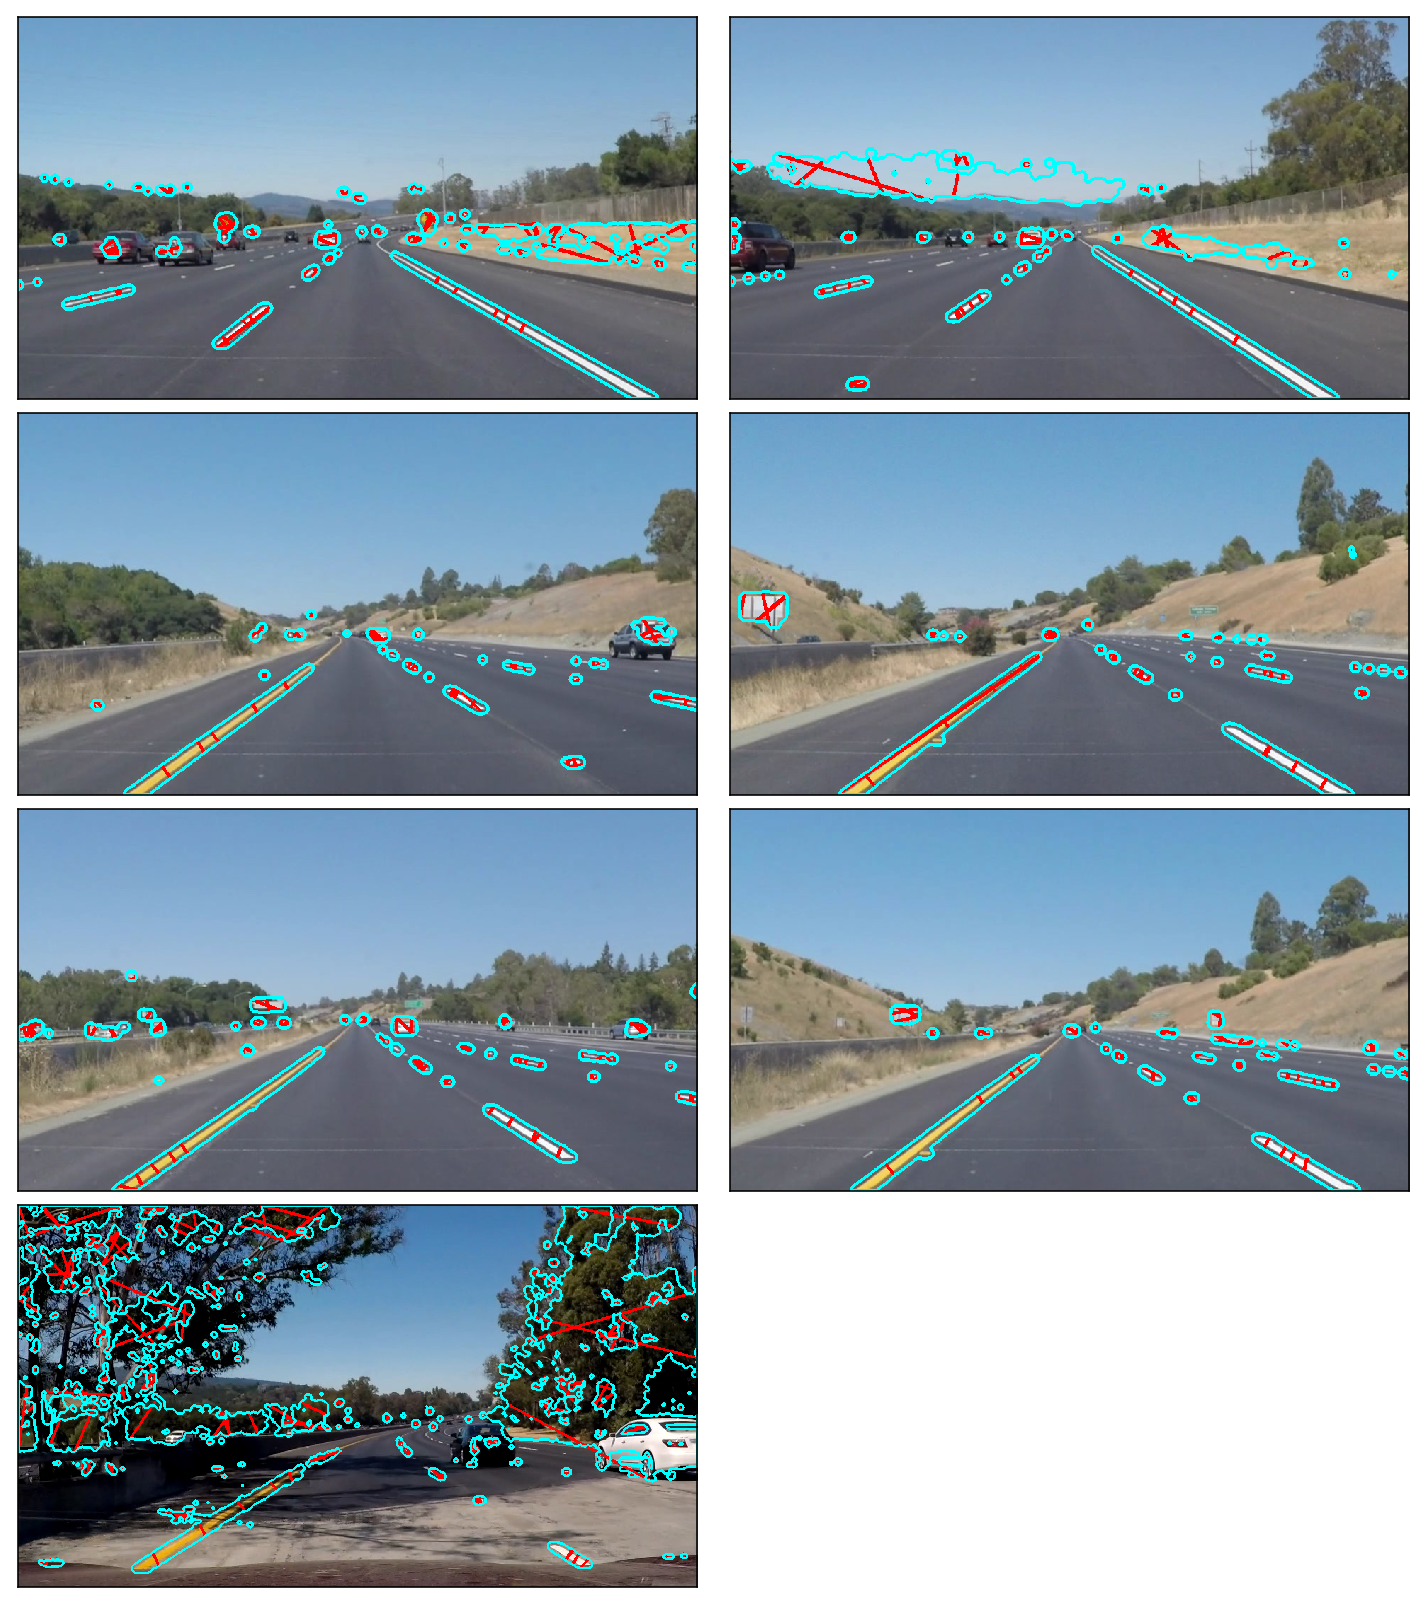

In [180]:
def gen_contour_dirs(pts, stride = 20):
    # use statistics for a robust version of this
    if len(pts) < stride:
        return None
    dirs = []
    for i in range(len(pts)):
        p0 = pts[i]; p1 = pts[(i+stride) % len(pts)];
        dirs.append(np.subtract(p1, p0))
    return dirs
def find_opposing_point_1(pts, dirs, pi0):
    min_pi = -1; min_dist = 0.0;
    for pi in [x%len(pts) for x in range(pi0 + int(0.2*len(pts)), pi0 + int(0.8*len(pts)))]:
        #print pi, dirs[pi0], dirs[pi]
        if np.dot(dirs[pi], dirs[pi0]) < -0.5:
            pi_dist = np.linalg.norm(np.subtract(pts[pi0], pts[pi]))
            if min_pi == -1 or pi_dist < min_dist:
                min_pi = pi; min_dist = pi_dist
    return min_pi
def intersect_lines(p1, d1, p2, d2):
    try:
        t = np.linalg.solve(np.transpose([d1,np.multiply(d2, -1.0)]), np.subtract(p2, p1))
        return t[0], np.add(p1, np.multiply(d1, t[0]))
    except np.linalg.linalg.LinAlgError:
        return (None, None)
def project_pt_line(p, d, pt):
    k = np.dot(np.subtract(pt, p), d) / np.square(np.linalg.norm(d))
    return np.add(p, np.multiply(d, k))
def find_opposing_point(contour_pts, dirs, pi0, safety=0):
    if np.linalg.norm(dirs[pi0] == 0.0):
        return -1
    p0 = contour_pts[pi0]; d0 = [-dirs[pi0][1], dirs[pi0][0]];
    min_i = -1; min_score = 0.0; min_pt = None;
    for i in range(len(contour_pts)):
        if (abs(i - pi0) >= safety):
            proj_pt = project_pt_line(p0, d0, contour_pts[i])
            de = np.linalg.norm(np.subtract(proj_pt, contour_pts[i]))
            dp = np.linalg.norm(np.subtract(proj_pt, p0))
            i_score = de - dp
            if min_i == -1 or i_score < min_score:
                min_i = i; min_score = i_score;
    return min_i
def contour_is_lane(contour_pts):
    return True
contour_images = []
for i, img in enumerate(blurred_images):
    img2, contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    if i not in g_dbg_indices:
        contour_images.append(img2)
        continue
    tgt = copy.copy(src_images[i])
    for contour in [x for x in contours[:]]:
        contour_pts = [x[0] for x in contour] # I don't get this...
        contour_dirs = gen_contour_dirs(contour_pts, 4)
        is_lane = contour_is_lane(contour_pts)
        if contour_dirs is not None:
            for ti in range(5):
                pi0 = np.random.randint(len(contour_pts)-1)
                #pi0 = 40
                opp_pi = find_opposing_point(contour_pts, contour_dirs, pi0)
                if opp_pi != -1:
                    p0 = contour_pts[pi0]; d0 = [int(x) for x in [-contour_dirs[pi0][1], contour_dirs[pi0][0]]];
                    cv2.line(tgt, tuple(contour_pts[opp_pi]), tuple(p0), [255,0,0], thickness=4)        
        col = [int(x*255) for x in np.random.rand(3,1)]
        col = [0,255,255] if is_lane else [255,0,0]
        tgt = cv2.drawContours(tgt, [contour], -1, col, 3)
    contour_images.append(tgt)
show_images(contour_images, 'contour')

In [ ]:
# next: feature engineer the lanes, curvature. simply random points within blob, then 'lane-string-pull'? is there 
# a model of classifying using perspective information not knowing the scale or is there not?